<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Algorithm 7 - Random Forest Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Part 1: Malawi Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction)  
&nbsp;&nbsp;&nbsp;[Explanation and Theory](#introduction-theory)  
&nbsp;&nbsp;&nbsp;[Considerations](#introduction-considerations)  
[Data Setup](#setup)  
[Scikit-Learn Random Forest Classifier](#sklearn-rf)  
&nbsp;&nbsp;&nbsp;[Include All Features](#all-feats)  
&nbsp;&nbsp;&nbsp;[Tune Parameters and Cross-Validate](#tune-cv)  
[AdaBoost](#ada-boost) 
[Feature Selection](#feature-selection)  
[Summary](#summary)

# Random Forest Classifier Introduction <a class="anchor" id="introduction"></a>

As we saw in the [decision trees notebook](6.0-dt-mwi.ipynb), trees are simple and fast but they tend to suffer from high variance and overfit the training data. Random forests mitigate this problem using a combination of bootstrap aggregation and random subspace sampling to create an ensemble – a forest – of many decorrleated trees that typically outperform any inidividual CART. Random forests will be discussed in the context of decision trees, but keep in mind that the methodology could be applied to any set of base learners, although decision trees are by far the most common choice.

## Explanation and Theory <a class="anchor" id="introduction-theory"></a>

**Assumptions and properties.** Since we are still considering decision trees, many of the same properties hold. Random forests handle mixed predictors just as well, and need not make any assumptions about the underlying distribution of the data. However, Random forests rely on two new ideas we haven't seen in previous notebooks: bootstrap aggregation and random subspace sampling.

_Bootstrap aggregation (Bagging)._ Bootstrapping is a way to simulate repeating an experiment and obtaining different distributions of data. Given a dataset $D$, suppose we sample some subset $S_{1}\subset D$ and then grow a tree with $S_{1}$ as the training set. Suppose we then _replace the sample and resample a new subset_ $S_{2}$, and grow yet another tree using $S_{2}$ as the training data. Some of the data in $S_1$ may also be in $S_2$, but if we repeat the process many times, we are bound to get some distinct datasets, and we will in turn get a collection of trees with different structures. Now, instead of basing our classification on a single tree, we can take votes across many trees.

This approach is called bootstrap aggregation, or bagging. It acts to reduce the variance in the resulting model by providing many different training conditions in which to grow trees. This helps smooth the decision boundary used in the model and typically improves performance compared to a single tree.

The limitation of purely bagging is that the reduction in variance is bounded by inherent correlation between trees. The correlation results from the bootstrapping process: since the same dataset is resampled many times with replacement, many of the resulting trees choose similar split conditions, leading to correlation between trees. Random forests take things one step further by mitigating correlation between trees using random subspace sampling as well.

_Random subspace sampling._ Also called "feature bagging," the random subspace approach to training many trees works as follows. Given a dataset $D$, a $d$-dimensional datapoint of that set might look like $x_i = (x_{i1},\dots, x_{ij},\dots x_{id})$. The idea of feature bagging while growing trees is the following. Instead of considering each feature $1, \dots, d$, when choosing a split variable, we consider a random subset of $k<d$ features. So if the data $x\in D$ has 100 dimensions, maybe we randomly select 10 of those dimensions and grow a tree considering _only_ those 10 features. We can then grow a collection of trees where each tree grew according to a different randomly chosen subset of features.

_Random forest._ A random forest simply combines bootstrapping and random subspace sampling. A random subset of data $S \subset D$ is chosen to grow a tree, and then a random subset of $k<d$ features are used to split the tree. The rest of the features and data are ignored. This process is repeated many times and a forest of decision trees is grown. The problem of tree correlation is mitigated by randomly choosing features for each bootstrap sample, and the overall model has much lower variance than both a standard "bag of trees" and especially a single tree. The resulting ensemble is one of the best predictors in machine learning!

**Algorithm and Training.**

The training procedure is similar to that used in CART, as [discussed in the previous notebook](6.0-dt-mwi.ipynb#introduction-theory). Everything about growing an individual decision tree holds here, only now we are growing many. 

What's new here is that for each tree grown, we are using only a random subset of the full training dataset. Further, we are choosing only a random subset of features to consider. The random selections are made with replacement, and a forest of many trees is grown. Given a new datapoint, we simply take the majority vote (for classification) or the average (for regression). The contribution of many decorrelated trees helps smooth the decision boundaries used for prediction.

## Considerations <a class="anchor" id="introduction-considerations"></a>

This and other ensemble methods offer a natural alternative to cross-validation called out-of-bag (OOB) error. The idea is to monitor prediction performance by testing the model on whatever data isn't being used in the current bootstrap sample. This approach can be used to monitor training and overfitting.

Again, since our random forests are merely a collection of decision trees, most of the considerations made for CART hold here. The exception of course the problem of high variance, since the entire point of random forests is to mitigate the high variance overfitting problem.

# Data setup <a class="anchor" id="setup"></a>

First, load in the standard libraries and inspect the training data. 

In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize
from features.process_features import MWI_BASIC_FEATURES

ALGORITHM_NAME = 'rf'
COUNTRY = 'mwi'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_train.poor.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 9,183 rows and 484 columns
Percent poor: 45.1% 	Percent non-poor: 54.9%


,der_hhsize,hld_rooms,hld_nbcellpho,hld_selfscale,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpastyear,hld_dwelloccu__Employer provides,...,com_medicines__Yes,com_clinic__Yes,com_distclinic__11 to 15 kilometers,com_distclinic__16 to 20 kilometers,com_distclinic__21 to 25 kilometers,com_distclinic__26 to 30 kilometers,com_distclinic__6 to 10 kilometers,com_distclinic__Above 30 kilometers,com_distclinic__nan,com_bank__Yes
hid,,,,,,,,,,,,,,,,,,,,,
304044580160,5,3,0.0,1.0,3,1,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
205205820123,3,2,1.0,3.0,1,1,1,2,1,0,...,1,0,0,0,0,0,0,0,0,0
102016880095,6,5,0.0,2.0,3,1,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
315356330210,3,3,3.0,3.0,1,1,1,3,1,0,...,1,1,0,0,0,0,0,0,1,1
313061660067,2,1,0.0,2.0,0,1,1,2,0,0,...,1,0,0,1,0,0,0,0,0,0


# Scikit-Learn Random Forest Model <a class="anchor" id="sklearn-rf"></a>

In [3]:
selected_columns = MWI_BASIC_FEATURES
print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (9183, 9)


In [4]:
# Create DataFrame of feature importances
def get_feat_imp_df(feat_imps, index=None, sort=True):
    feat_imps = pd.DataFrame(feat_imps, columns=['importance'])
    if index is not None:
        feat_imps.index = index
    if sort:
        feat_imps = feat_imps.sort_values('importance', ascending=False)
    return feat_imps

CPU times: user 65.8 ms, sys: 0 ns, total: 65.8 ms
Wall time: 65.8 ms
CPU times: user 20.2 ms, sys: 182 µs, total: 20.4 ms
Wall time: 20.1 ms
In-sample score: 81.15%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


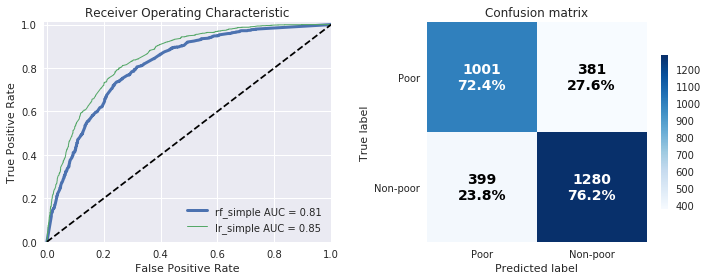

,rf_simple,lr_simple
accuracy,0.745181,0.766743
recall,0.724313,0.738784
precision,0.715,0.743086
f1,0.719626,0.740929
cross_entropy,1.10248,0.478969
roc_auc,0.810679,0.847856
cohen_kappa,0.486111,0.528811


Actual poverty rate: 54.11% 
Predicted poverty rate: 58.08% 


In [5]:
from sklearn.ensemble import RandomForestClassifier

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, 
                                      selected_columns=selected_columns)

# Fit the model
model = RandomForestClassifier()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, 
                                   selected_columns=selected_columns)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    compare_models=['lr_simple'],
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

The Random Forest model provides feature importances, so we can inspect and rank the features

In [6]:
feat_imps

,importance
der_nchild10under,0.230716
der_nliterate,0.156354
der_nfemalesover10,0.127710
cons_0508__Yes,0.122959
der_nmalesover10,0.116918
cons_0504__Yes,0.097515
der_nemployedpastyear,0.061826
hld_electricity__Yes,0.060713
hld_toilet__None,0.025288


## Random Forest with all features <a class="anchor" id="all-feats"></a>

Now let's try using the full feature set

CPU times: user 371 ms, sys: 16.6 ms, total: 388 ms
Wall time: 387 ms
CPU times: user 63.9 ms, sys: 18 ms, total: 82 ms
Wall time: 94 ms
In-sample score: 99.35%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


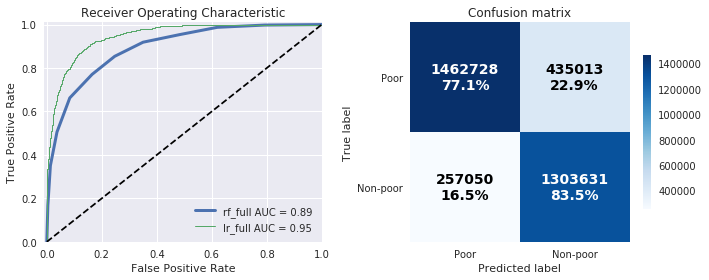

,rf_full,lr_full
accuracy,0.799891,0.873897
recall,0.770773,0.869754
precision,0.850533,0.853693
f1,0.808691,0.861649
cross_entropy,0.500359,0.288223
roc_auc,0.892454,0.948658
cohen_kappa,0.613488,0.745821


Actual poverty rate: 54.11% 
Predicted poverty rate: 52.57% 


In [7]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = RandomForestClassifier()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full',
                                    store_model=True,
                                    model_name='full', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

The default model gives us decent results on the full dataset, but the high in-sample score is a good indication of over-fitting. Let's modify some of the parameters to see if we can mitigate this.

CPU times: user 3.11 s, sys: 13.8 ms, total: 3.13 s
Wall time: 7.1 s
CPU times: user 371 ms, sys: 0 ns, total: 371 ms
Wall time: 1.31 s
In-sample score: 94.58%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


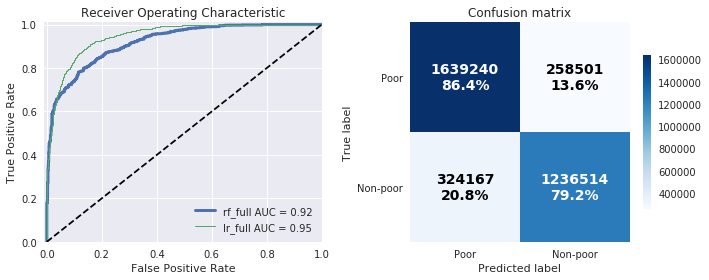

,rf_full,lr_full
accuracy,0.831522,0.873897
recall,0.863785,0.869754
precision,0.834896,0.853693
f1,0.849095,0.861649
cross_entropy,0.392563,0.288223
roc_auc,0.920024,0.948658
cohen_kappa,0.662545,0.745821


Actual poverty rate: 54.11% 
Predicted poverty rate: 56.17% 


In [8]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_leaf=5, min_samples_split=5)
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full',
                                    store_model=True,
                                    model_name='full', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

As with Decision Trees, we have the option to include sample weights with this classifier.

CPU times: user 3.41 s, sys: 34.2 ms, total: 3.44 s
Wall time: 4.6 s
CPU times: user 433 ms, sys: 22.8 ms, total: 456 ms
Wall time: 1.11 s
In-sample score: 94.83%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


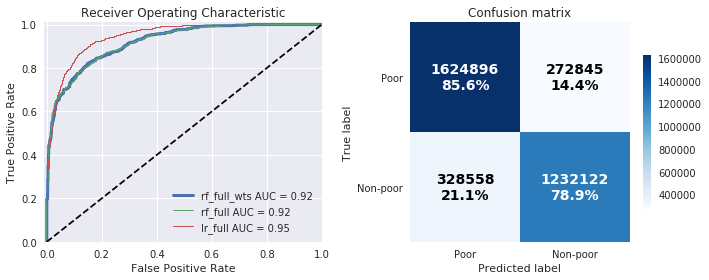

,rf_full_wts,rf_full,lr_full
accuracy,0.826105,0.831522,0.873897
recall,0.856226,0.863785,0.869754
precision,0.831807,0.834896,0.853693
f1,0.84384,0.849095,0.861649
cross_entropy,0.392543,0.392563,0.288223
roc_auc,0.920383,0.920024,0.948658
cohen_kappa,0.648247,0.662545,0.745821


Actual poverty rate: 54.11% 
Predicted poverty rate: 55.78% 


In [9]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = RandomForestClassifier(n_estimators=100, 
                               max_depth=20, 
                               min_samples_leaf=5, 
                               min_samples_split=5)
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['rf_full', 
                                                    'lr_full'],
                                    store_model=True,
                                    model_name='full_wts', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

## Tune parameters and cross-validate <a class="anchor" id="tune-cv"></a>



/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/model_selection/_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   37.6s finished


CPU times: user 7.23 s, sys: 637 ms, total: 7.86 s
Wall time: 49.9 s
CPU times: user 373 ms, sys: 0 ns, total: 373 ms
Wall time: 1.09 s
In-sample score: 89.28%
Best model parameters: {'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


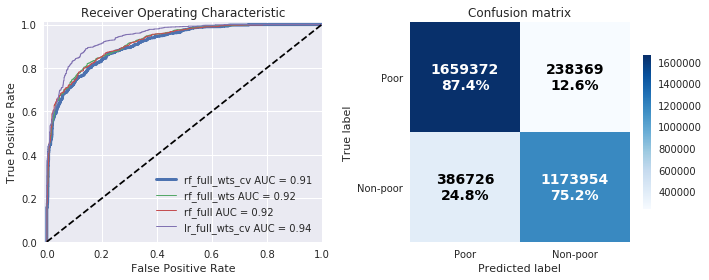

,rf_full_wts_cv,rf_full_wts,rf_full,lr_full_wts_cv
accuracy,0.819254,0.826105,0.831522,0.873458
recall,0.874393,0.856226,0.863785,0.891581
precision,0.810993,0.831807,0.834896,0.87947
f1,0.841501,0.84384,0.849095,0.885484
cross_entropy,0.406672,0.392543,0.392563,0.300498
roc_auc,0.912814,0.920383,0.920024,0.944474
cohen_kappa,0.613513,0.648247,0.662545,0.734446


Actual poverty rate: 54.11% 
Predicted poverty rate: 59.35% 


In [10]:
from sklearn.model_selection import GridSearchCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# build the model
estimator = RandomForestClassifier()
parameters = {'n_estimators': [10, 50, 100],
              'max_depth': np.arange(1,16,5), 
              'min_samples_split': np.arange(2,21,10),
              'min_samples_leaf': np.arange(1,46,20)
             }
fit_params = {'sample_weight': w_train}
model = GridSearchCV(estimator, parameters, fit_params=fit_params, verbose=1, cv=5, n_jobs=-1)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)
feat_imps = get_feat_imp_df(model.best_estimator_.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['rf_full_wts',
                                                    'rf_full',
                                                    'lr_full_wts_cv'],
                                    store_model=True,
                                    model_name='full_wts_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)
best_model = model.best_estimator_

This gives us a noticeable boost in performance, with a better recall and much lower cross-entropy than the default model. 

In [11]:
feat_imps.head(20)

,importance
cons_0901__Yes,0.056906
der_hhsize,0.038312
cons_0801__Yes,0.034154
hld_nbcellpho,0.027160
cons_1204__Yes,0.026416
der_nchild10under,0.024181
cons_0508__Yes,0.023908
cons_0106__Yes,0.023428
cons_0401__Yes,0.022907
cons_0803__Yes,0.022776


# AdaBoost Random Forest Classifier <a class="anchor" id="ada-boost"></a>

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 47.4min finished


CPU times: user 9min 2s, sys: 4.24 s, total: 9min 6s
Wall time: 56min 24s
CPU times: user 45.7 s, sys: 331 ms, total: 46 s
Wall time: 46 s
In-sample score: 100.00%
Best model parameters: {'learning_rate': 1, 'n_estimators': 400}


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/tree/tree.py:508: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


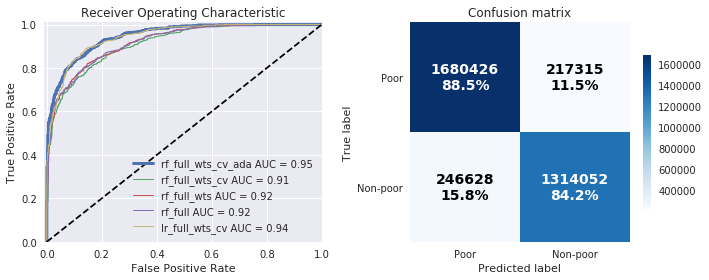

,rf_full_wts_cv_ada,rf_full_wts_cv,rf_full_wts,rf_full,lr_full_wts_cv
accuracy,0.865851,0.819254,0.826105,0.831522,0.873458
recall,0.885488,0.874393,0.856226,0.863785,0.891581
precision,0.872018,0.810993,0.831807,0.834896,0.87947
f1,0.878701,0.841501,0.84384,0.849095,0.885484
cross_entropy,0.594091,0.406672,0.392543,0.392563,0.300498
roc_auc,0.947686,0.912814,0.920383,0.920024,0.944474
cohen_kappa,0.744254,0.613513,0.648247,0.662545,0.734446


Actual poverty rate: 54.11% 
Predicted poverty rate: 54.32% 


In [12]:
from sklearn.ensemble import AdaBoostClassifier

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# build the model
estimator = AdaBoostClassifier(best_model)

parameters = {'n_estimators': [50, 100, 200, 400], 
              'learning_rate': [0.001, 0.01, .1, 1]
             }
fit_params = {'base_estimator__sample_weight': w_train}
model = GridSearchCV(estimator, parameters, verbose=1, cv=5, n_jobs=-1)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)
feat_imps = get_feat_imp_df(model.best_estimator_.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['rf_full_wts_cv', 
                                                    'rf_full_wts',
                                                    'rf_full',
                                                    'lr_full_wts_cv'],
                                    store_model=True,
                                    model_name='full_wts_cv_ada', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)
best_model = model.best_estimator_

# Feature selection <a class="anchor" id="feature-selection"></a>

Since this model provides feature importances, we can easily remove features that do not contribute much to the model. For example, we can filter our features to only those that contribute 80% of the model importance. In the case of filtering consumable features, we can quickly see which are most useful and filter it to the top 50 or less.

X shape after feature selection:  (9183, 190)
CPU times: user 9.31 s, sys: 44.3 ms, total: 9.35 s
Wall time: 9.35 s
CPU times: user 964 ms, sys: 28 µs, total: 964 ms
Wall time: 962 ms
In-sample score: 99.87%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


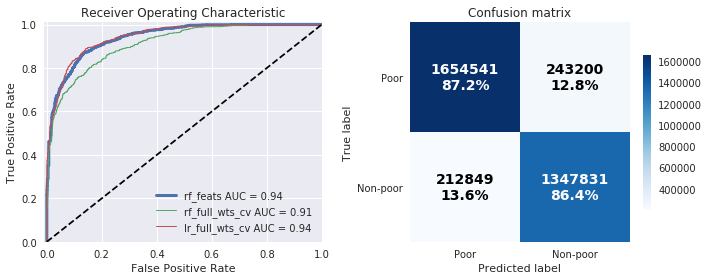

,rf_feats,rf_full_wts_cv,lr_full_wts_cv
accuracy,0.868134,0.819254,0.873458
recall,0.871847,0.874393,0.891581
precision,0.886018,0.810993,0.87947
f1,0.878876,0.841501,0.885484
cross_entropy,0.474121,0.406672,0.300498
roc_auc,0.941116,0.912814,0.944474
cohen_kappa,0.742232,0.613513,0.734446


Actual poverty rate: 54.11% 
Predicted poverty rate: 53.99% 


In [13]:
feats = feat_imps[feat_imps.cumsum() <= 0.80].dropna().index.values

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, selected_columns=feats)
print("X shape after feature selection: ", X_train.shape)

# Fit the model
model = best_model
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, selected_columns=feats)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['rf_full_wts_cv', 
                                                    'lr_full_wts_cv'],
                                    store_model=True,
                                    model_name='feats', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

In [14]:
cons_feats = [x.split('__')[0] for x in feats if x[0:5] == 'cons_']
print("{} consumables features selected:".format(len(cons_feats)))
for x in cons_feats:
    print(questions[x])

81 consumables features selected:
Thobwa
Bean, brown
Sugar
Cooking oil
Chicken
Dried fish
Maize ufa refined (fine flour)
Banana
Green maize
Glycerine, Vaseline, skin creams
Cassava tubers
Maize ufa mgaiwa (normal flour)
Pumpkin
Tanaposi/Rape
Paraffin or kerosene
Rice
Grass for thatching roof or other use
Nkhwani
Donation - to church, charity, beggar, etc.
Groundnut
Fresh fish
Eggs
Okra / Therere
Tomato
White sweet potato
Mango
Groundnut flour
Woodpoles, bamboo
Mat - sleeping or for drying maize flour
Pigeonpea (nandolo)
Onion
Matches
Other cultivated green leafy vegetables
Chitenje cloth
Bean, white
Batteries
Buns, scones
Funeral costs, nonhousehold members (relatives, neighbors/friends)
Tea
Mandazi, doughnut (vendor)
Sugar Cane
Gathered wild green leaves
Clothes soap (powder)
Cowpea (khobwe)
Yeast, baking powder, bicarbonate of soda
Other personal products (shampoo, razor blades, cosmetics, hair products, etc.)
Bar soap (body soap or clothes soap)
Orange sweet potato
Toothpaste, tooth

# Random Forest Classifier Malawi Summary <a class="anchor" id="summary"></a>



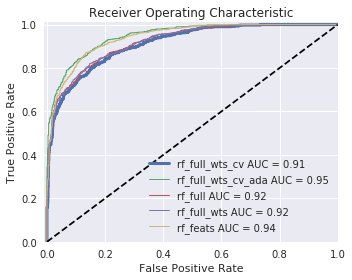

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error
rf_full_wts_cv,0.819254,0.874393,0.810993,0.841501,0.406672,0.912814,0.613513,0.05244
rf_full_wts_cv_ada,0.865851,0.885488,0.872018,0.878701,0.594091,0.947686,0.744254,0.00208431
rf_full,0.831522,0.863785,0.834896,0.849095,0.392563,0.920024,0.662545,0.0206509
rf_full_wts,0.826105,0.856226,0.831807,0.84384,0.392543,0.920383,0.648247,0.0166835
rf_feats,0.868134,0.871847,0.886018,0.878876,0.474121,0.941116,0.742232,-0.00115567


In [15]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)